# Objective: Segmentation of tangrams from an image and a surface

In [1]:
from torch_pdegraph.operators import GradMinusNorm
import torch
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from torch_pdegraph.utilities import *
from tqdm import tqdm
import matplotlib.pyplot as plt
import faiss

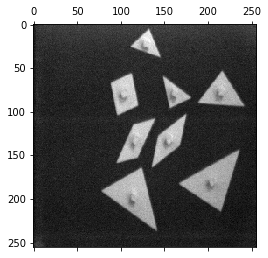

In [2]:
# load the tangram image
img = mpimg.imread("../data/tangram.png")
dispImg(img)

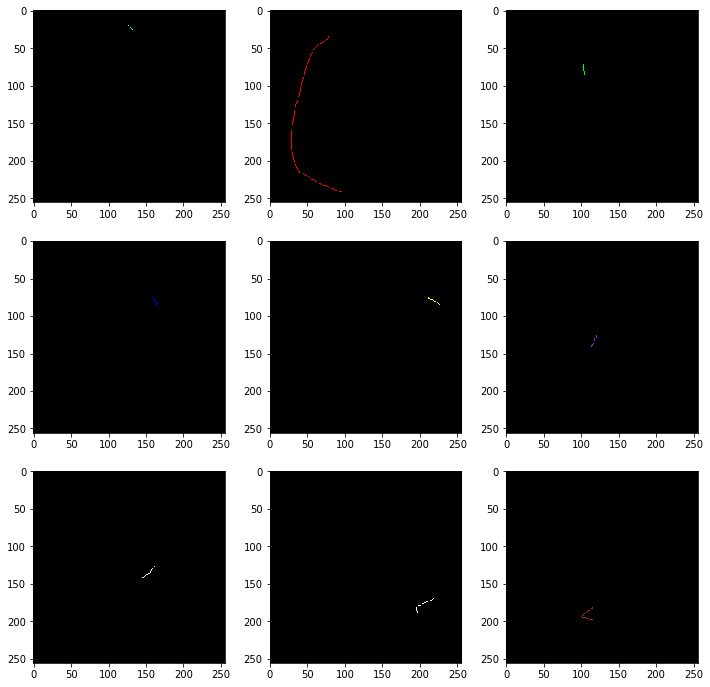

In [5]:
# InitialFronts/initial_distances are seeds on the image (on each tangram  and backgroun)
# One can use any image annotation tool to create hese  seeds I have used Pandore by Greyc
f = plt.figure(figsize=(12,12))
Front = []  
for i in range(1,10,1):
    seed = mpimg.imread(f"../data/dist_{i}.png")
    f.add_subplot(3,3,i)
    plt.imshow(seed, cmap="gray")
    initial_dist = getDist(seed)
    Front.append(initial_dist)

# Graph construction

- In order to simply show the effectiveness of PDEs on graph,  I am only creating a simple K-NN based graphs. This may or maynot be the best graph for a given problem at hand.

- One can create graph using whatsoever apt approach or one can even use third-party network datasets and run a PDE on that graph.  PDEs are extensible to any given graph/network at hand as long as that graph has edges and weights( edge_index and edge_attr).

Although torch_cluster comes with a knn-graph method. I found it to be limited and  slow when the node-features have high dimensions. We shall be using facebook's faiss library which is blazingly fast for a KNN-graph construction.

In [6]:
p = toPmat(img.shape).astype(np.float32) # position coords vector
texture = toFmat(img).flatten() # gray-scale values

# Create a KNN graph using the (x,y) pixel-coord of the image and assign weights using differnce
# between the texture at the pixel-coords
res = faiss.StandardGpuResources()
index = faiss.IndexFlatL2(p.shape[1])
gpu_index_flat = faiss.index_cpu_to_gpu(res,0,index)
gpu_index_flat.add(p)
k = 10
_, I = gpu_index_flat.search(p,k+1)


#Graph 
edge_index = np.vstack((I[:,1:].flatten(), np.repeat(I[:,0].flatten(),10)))
edge_attr = np.exp(-((texture[I]-texture[I][:,0,None])**2)/1e-04)[:,1:].flatten()
edge_index = torch.tensor(edge_index, dtype=torch.long).to('cuda:0')
edge_attr = torch.tensor(edge_attr, dtype=torch.float32).to('cuda:0')
edge_attr = edge_attr.view(-1,1)
graph = Graph(edge_index, edge_attr)

# Run a manually defined PDE:

\begin{equation}
\mathbf{x}^{n+1}_{i}  = \mathbf{x}^{n}_{i} + \Delta t \ (\mathbf{1} - \|\nabla^{-}_{w}\ \mathbf{x}^{n}_{i}\|_{p})\\
\end{equation}

- $\mathbf{x}_{i}$ is the node feature/signal at the $i^{th}$ node
- $\nabla^{-}_{w}$ is the negative directional gradient on weighted graphs

**Example:** 
```python
from torch_pdegraph.operators import GradMinusNorm
ope = GradMinusNorm.OPE(graph, **hp) # create an operator instance

for i in range(itr): # run the manual pde inside a loop
     fr = fr + dt * (1.0 - ope(fr)) 
```

Though not exactly, this equation is approximates time depenendent **eikonal equation on weighted graphs which can be used to calculate generalized distances on the graphs**. Check the [Thong](https://hal.archives-ouvertes.fr/file/index/docid/404070/filename/VinhThongTA_09_ssvm.pdf)


In [7]:
# Params
dt = 0.05
itr = 5000
hp = dict(p_val = 1)

# Evolved Front
new_front = []

# Instantiate the operator
ope = GradMinusNorm.OPE(graph, **hp)

# Run explict PDE
for fr in tqdm(Front):
    fr = toFmat(fr)
    fr = torch.tensor(fr, dtype=torch.float32).to('cuda:0')
    for i in range(itr):
        fr = fr + dt * (1.0 - ope(fr))
    newfr = fr.to('cpu')
    new_front.append(newfr.numpy())

100%|██████████| 9/9 [00:11<00:00,  1.27s/it]


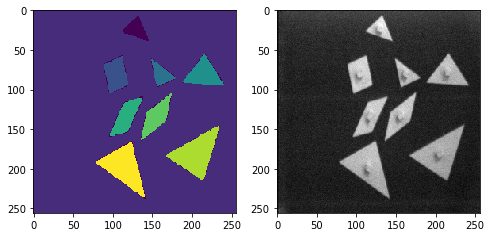

In [8]:
# visualize the segmented image
dist_img = []
for fr in new_front:
    tmp_img = toImg(fr, img.shape[0:2])
    dist_img.append(tmp_img)
m = np.argmin(dist_img, axis=0)

import matplotlib.pyplot as plt
f = plt.figure(figsize=(8,8))
f.add_subplot(1,2, 1)
plt.imshow(m) # Segmented image
f.add_subplot(1,2, 2)
plt.imshow(img, cmap="gray") # Orignal image
plt.show(block=True)

# Reproduce the result for a pointcloud

In [10]:
# Same thing reproduction for a point clould surface
p = np.load("../data/tangram/position_tangram.npz")
t = np.load("../data/tangram/smooth_texture_tangram.npz")
p = p["position"].astype(np.float32)
signal = t["texture"]


# Create a knn graph
res = faiss.StandardGpuResources()
index = faiss.IndexFlatL2(p.shape[1])
gpu_index_flat = faiss.index_cpu_to_gpu(res,0,index)
gpu_index_flat.add(p)
k = 25
_, I = gpu_index_flat.search(p,k+1)
edge_index = np.vstack((I[:,1:].flatten(), np.repeat(I[:,0].flatten(),k)))
edge_attr = np.exp(-np.sum(((signal[I]-signal[I][:,0,None])**2),axis=2)/(1.3e-02)**2)[:,1:].flatten()
edge_index = torch.tensor(edge_index, dtype=torch.long).to('cuda:0')
edge_attr = torch.tensor(edge_attr, dtype=torch.float32).to('cuda:0')
edge_attr = edge_attr.view(-1,1)
graph = Graph(edge_index, edge_attr)


# load the intial_distance/seed pcd
Front = []  # tiff should be preffered than png
for i in range(1,10,1):
    seed = np.load(f"../data/tangram/{i}_texture.npz")
    seed = seed["texture"]
    initial_dist = getDistPcd(seed)
    initial_dist = np.reshape(initial_dist, (len(initial_dist),1))
    Front.append(initial_dist)

# solve the pde
dt = 0.05
itr = 5000
new_front = []
hp = dict(p_val = 1)
ope = GradMinusNorm.OPE(graph, **hp)
for fr in tqdm(Front):
    fr = torch.tensor(fr, dtype=torch.float32).to('cuda:0')
    for i in range(itr):
        fr = fr + dt * (1.0 - ope(fr))
    newfr = fr.to('cpu')
    new_front.append(newfr.numpy())


100%|██████████| 9/9 [00:21<00:00,  2.34s/it]


In [11]:
#visualzie the segmented pcd
m = np.argmin(new_front, axis=0)
# m2 = np.min(dist_img,axis=0) Minimal distance image
# net_img = np.sum(dist_img,axis=0) Total distance image
m_t = np.uint8(255*(m/np.max(m)))
import cv2 as cv
t_c = cv.applyColorMap(m_t,cv.COLORMAP_JET)/255
t_c = t_c[:,0,:]
t_c.shape
displayJSur(**dict(position=p, texture=t_c))#Or use displaySur for no jupyter visualization

JVisualizer with 1 geometries

In [12]:
displayJSur(**dict(position=p,texture=signal))#Or use displaySur for no jupyter visualization

JVisualizer with 1 geometries

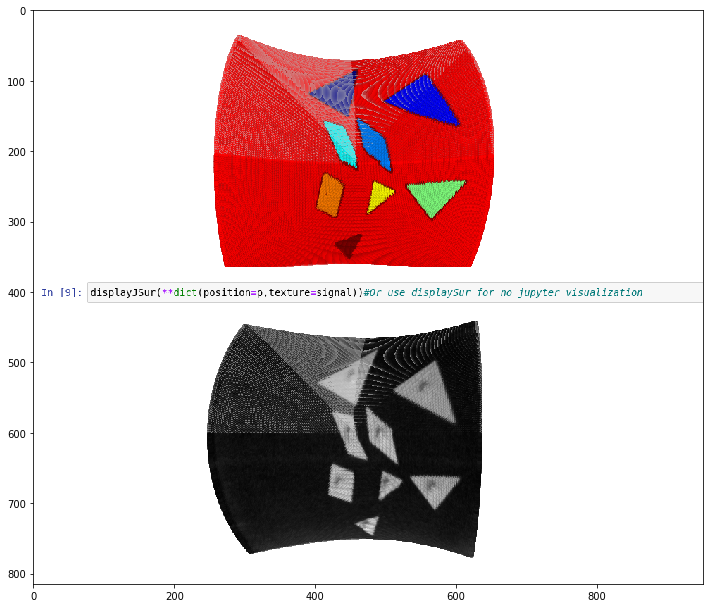

In [13]:
# Unlike an image, a pcd display cannot be saved in ipython notebook, hence the notebook must be running to 
# to view the pcd. Expect to see the tangrams segmented from the surface like shown in the following image.
from matplotlib import image as mpimg
from matplotlib import pyplot as plt
res = mpimg.imread("../gallery/tangram_surface.png")
f = plt.figure(figsize=(12,12))
plt.imshow(res)